In [1]:
import numpy as np

import astropy.units as u
from  astropy.coordinates import *

import sunpy.map
import sunpy.coordinates

import sunkit_image.coalignment as ski
import sunpy.physics.differential_rotation as diffrot

import matplotlib.pyplot as plt
from IPython.display import HTML, display

from glob import glob

This is my new function; I define it here so i can have a direct way to compare it with the actual version

In [2]:
def calculate_solar_rotate_shift(mc, layer_index=0, **kwargs):
       
    nt = len(mc.maps)
    xshift_arcseconds = np.zeros(nt) * u.arcsec
    yshift_arcseconds = np.zeros_like(xshift_arcseconds)
    observer_coordinate_ref_layer = mc.maps[layer_index].observer_coordinate

    for i, m in enumerate(mc):
        
        # Calculate the rotation of the center of the map 'm' at its
        # observation time to the observation time of the reference layer
        # indicated by "layer_index".
        new_coordinate = diffrot.solar_rotate_coordinate(m.center, observer=observer_coordinate_ref_layer, **kwargs)

        xshift_arcseconds[i] = new_coordinate.Tx - m.center.Tx
        yshift_arcseconds[i] = new_coordinate.Ty - m.center.Ty

    # Set the shifts relative to the reference layer
    # The shift of the reference layer is always zero by definition.
    xshift_ref=xshift_arcseconds[layer_index]
    yshift_ref=yshift_arcseconds[layer_index]
    xshift_arcseconds=xshift_arcseconds-xshift_ref
    yshift_arcseconds=yshift_arcseconds-yshift_ref
            

    return {"x": xshift_arcseconds, "y": yshift_arcseconds}

I use these 6 maps, given gently by @yjzhu-solar, to show the difference of the two methods.

He sad: "I prepared an AIA 193 map sequence consisting of six maps with one hour separation with each other. I manually made those cutouts so that the center coordinates of these maps are slightly different. "

In [3]:
# don't have to read the maps one by one
aia_files = sorted(glob("aia.lev1*.fits"))
aia_files

['aia.lev1_euv_12s.2024-01-04T190103Z.193.image.fits',
 'aia.lev1_euv_12s.2024-01-04T200103Z.193.image.fits',
 'aia.lev1_euv_12s.2024-01-04T210103Z.193.image.fits',
 'aia.lev1_euv_12s.2024-01-04T220103Z.193.image.fits',
 'aia.lev1_euv_12s.2024-01-04T230103Z.193.image.fits',
 'aia.lev1_euv_12s.2024-01-05T000103Z.193.image.fits']

In [4]:
#create map sequence
map_seq = sunpy.map.Map(aia_files, sequence=True) 

Showing the plots of the images

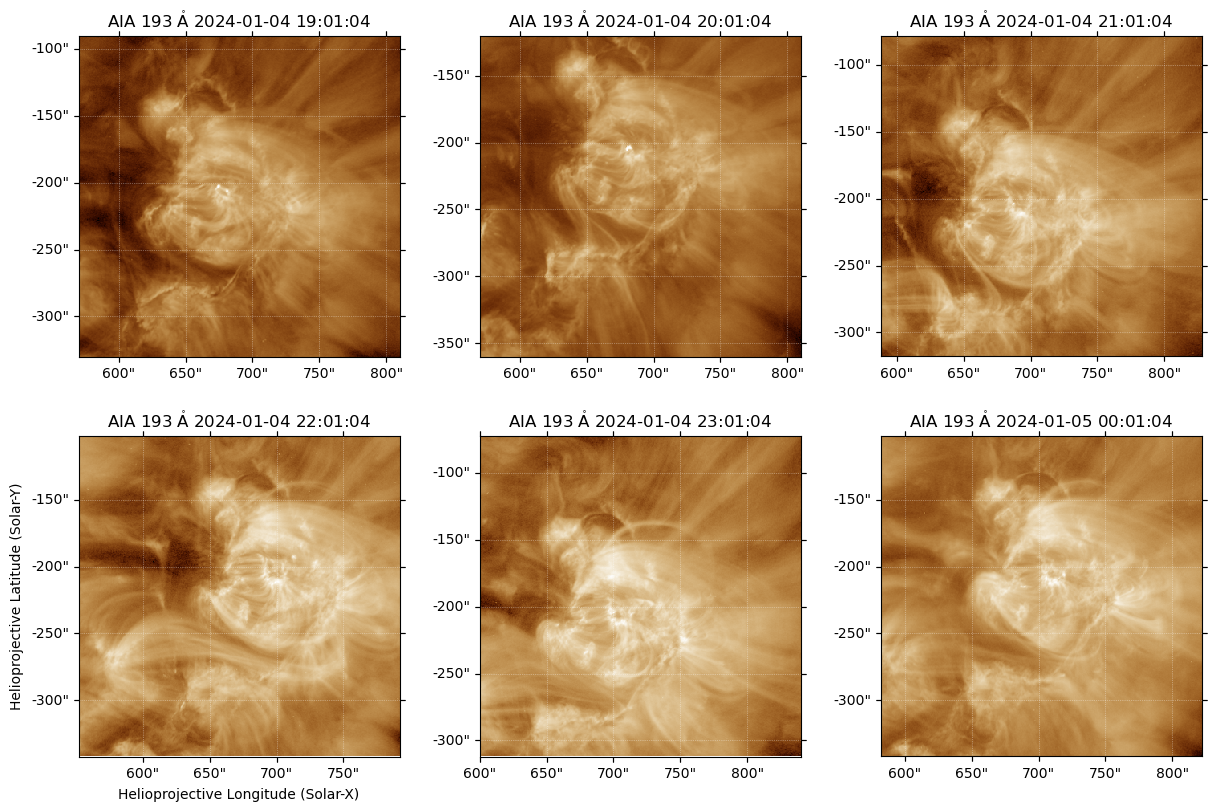

In [6]:
# show maps with coordinates
fig = plt.figure(figsize=(12, 8),layout='constrained')

for i, map_ in enumerate(map_seq):
    ax = fig.add_subplot(2, 3, i+1, projection=map_.wcs)
    map_.plot(axes=ax, cmap='sdoaia193')

    if i !=3:
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')

In the following part i show the different results that i get with these two  methods;

From the fact that the images are taken with equal delay (1 hour) the rotation should be smooth and
 the difference between each position on the array should be nearly costant.
 
In the following prompt we can see that in new method there is a nearly constant shift ~ 6 arcsec in Tx and ~0.3 arcsec in Ty. 

In [7]:
#calculate the shift using the actual method
oldShift=ski.calculate_solar_rotate_shift(map_seq, layer_index=0)
oldShift

{'x': <Quantity [  0.        ,  -6.13211901,   5.69057894, -37.3097058 ,
              5.61144133, -18.91259736] arcsec>,
 'y': <Quantity [  0.        , -29.69907601,  12.61877265, -11.16255802,
             19.24286322, -10.53098087] arcsec>}

In [8]:
#calculate the shift using the new method
newShift=calculate_solar_rotate_shift(map_seq, layer_index=0)
newShift

{'x': <Quantity [  0.        ,  -6.13211901, -12.30921682, -19.30989953,
            -24.3882123 , -30.91246239] arcsec>,
 'y': <Quantity [0.        , 0.30072454, 0.61879132, 0.83742729, 1.2428831 ,
            1.4688969 ] arcsec>}

In [9]:
#apply the shift to the map sequence, there is a bug with clip=True, I will create another issue
mapOldShift=ski.mapsequence_coalign_by_rotation(map_seq,shift=oldShift,clip=False)
mapNewShift=ski.mapsequence_coalign_by_rotation(map_seq,shift=newShift,clip=False)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


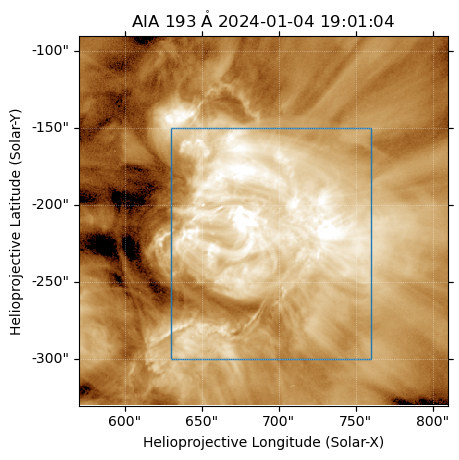

In [10]:
#find the rectangle area that is contained in all the maps
my_map=mapNewShift[0]
roi_bottom_left = SkyCoord(Tx=630*u.arcsec, Ty=-150*u.arcsec, frame=my_map.coordinate_frame)
roi_top_right = SkyCoord(Tx=760*u.arcsec, Ty=-300*u.arcsec, frame=my_map.coordinate_frame)

fig = plt.figure()
ax = fig.add_subplot(projection=my_map)
my_map.plot(axes=ax, clip_interval=(1,99.5)*u.percent)
my_map.draw_quadrangle(roi_bottom_left, top_right=roi_top_right, axes=ax, color='C0')
plt.show()

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


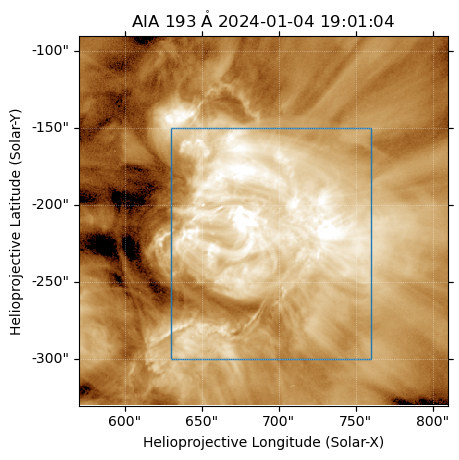

In [11]:
#find the rectangle area that is contained in all the maps
my_map=mapOldShift[0]
roi_bottom_left = SkyCoord(Tx=630*u.arcsec, Ty=-150*u.arcsec, frame=my_map.coordinate_frame)
roi_top_right = SkyCoord(Tx=760*u.arcsec, Ty=-300*u.arcsec, frame=my_map.coordinate_frame)

fig = plt.figure()
ax = fig.add_subplot(projection=my_map)
my_map.plot(axes=ax, clip_interval=(1,99.5)*u.percent)
my_map.draw_quadrangle(roi_bottom_left, top_right=roi_top_right, axes=ax, color='C0')
plt.show()

In [12]:
# now define skycoord for each coordinate frame because they could be slightly different
mapNewShiftCropped=[]
for m in mapNewShift:
    roi_bottom_left_ = SkyCoord(Tx=630*u.arcsec, Ty=-150*u.arcsec, frame=m.coordinate_frame)
    roi_top_right_ = SkyCoord(Tx=760*u.arcsec, Ty=-300*u.arcsec, frame=m.coordinate_frame)
    mapNewShiftCropped.append(m.submap(roi_bottom_left_,top_right=roi_top_right_))
mapNewShiftCropped = sunpy.map.Map(mapNewShiftCropped, sequence=True)

mapOldShiftCropped=[]
for m in mapOldShift:
    roi_bottom_left_ = SkyCoord(Tx=630*u.arcsec, Ty=-150*u.arcsec, frame=m.coordinate_frame)
    roi_top_right_ = SkyCoord(Tx=760*u.arcsec, Ty=-300*u.arcsec, frame=m.coordinate_frame)
    mapOldShiftCropped.append(m.submap(roi_bottom_left_,top_right=roi_top_right_))
mapOldShiftCropped = sunpy.map.Map(mapOldShiftCropped, sequence=True)

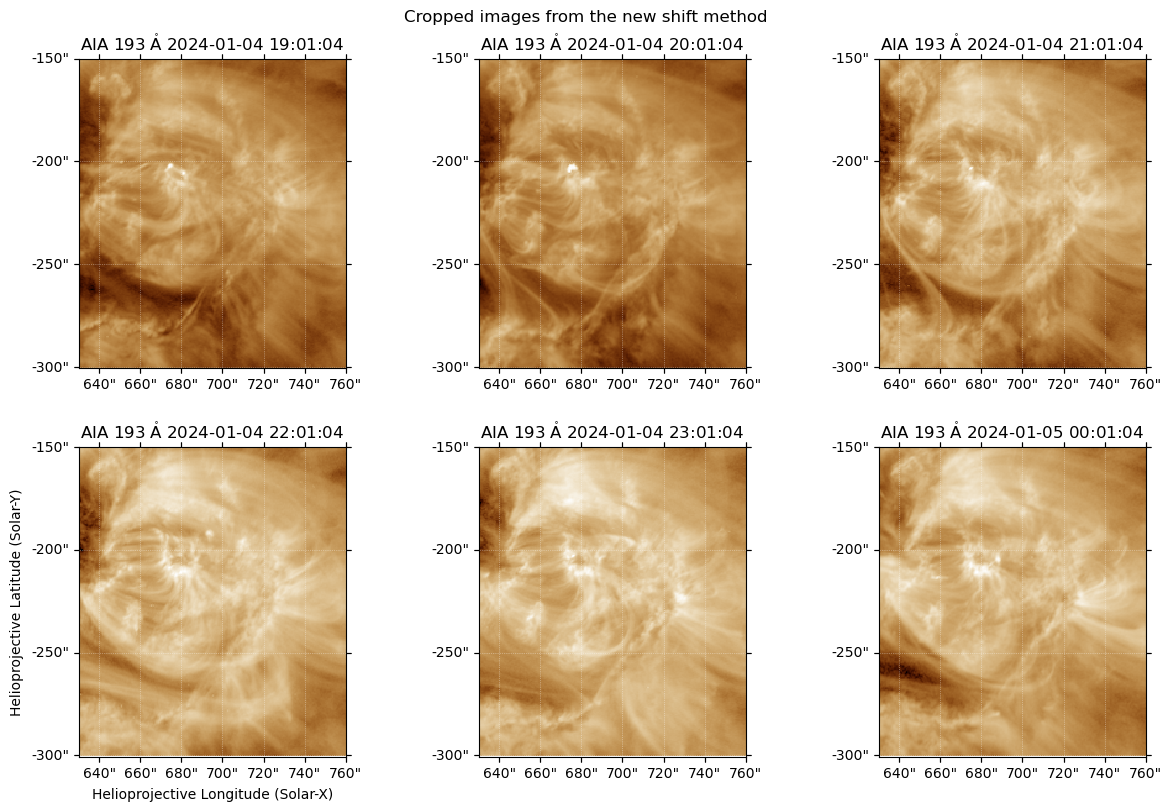

In [14]:
fig = plt.figure(figsize=(12, 8),layout='constrained')
fig.suptitle('Cropped images from the new shift method') 

for i, map_ in enumerate(mapNewShiftCropped):
    ax = fig.add_subplot(2, 3, i+1, projection=map_.wcs)
    map_.plot(axes=ax, cmap='sdoaia193')

    if i !=3:
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')

In [15]:
# add an animation to show better results
mapNewShiftAnimation = mapNewShiftCropped.plot().to_jshtml()
plt.close()
HTML(mapNewShiftAnimation)

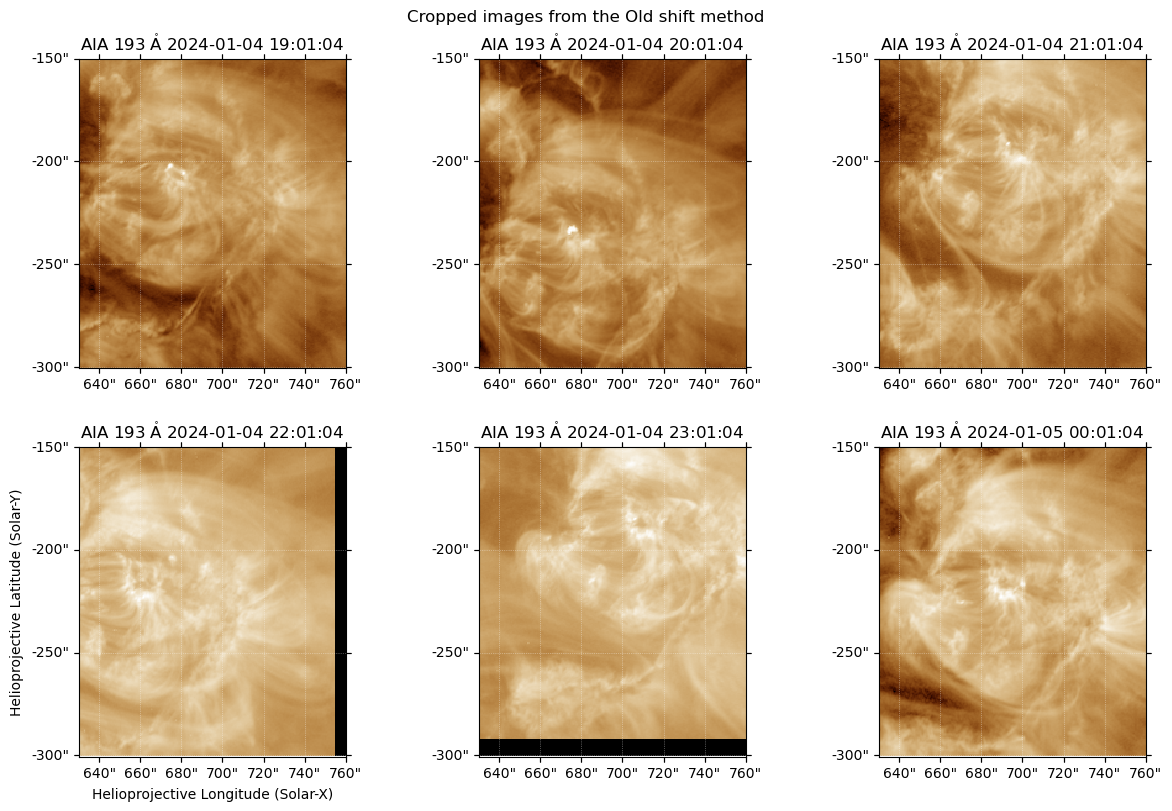

In [17]:
# show maps with coordinates
fig = plt.figure(figsize=(12, 8),layout='constrained')
fig.suptitle('Cropped images from the Old shift method')

for i, map_ in enumerate(mapOldShiftCropped):
    ax = fig.add_subplot(2, 3, i+1, projection=map_.wcs)
    map_.plot(axes=ax, cmap='sdoaia193')

    if i !=3:
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')

In [18]:
mapOldShiftAnimation = mapOldShiftCropped.plot().to_jshtml()
plt.close()
HTML(mapOldShiftAnimation)

It's hard to notice some differences in the imgaes becuase the difference consint in just tens of pixels.
(AIA has a spatial scale of 0.6 arcsec/pix)